In [1]:
import numpy as np

class KeerthiSmo:
    def __init__(self, data, class_labels, C, tolerance=1e-3, eps=1e-8, maxiter=1000):
        self.x = np.asarray(data, dtype=np.float64)
        self.y = np.asarray(class_labels, dtype=np.float64).reshape(-1, 1)
        self.N = self.y.shape[0]
        self.C = np.float64(C)
        self.tolerance = np.float64(tolerance)
        self.eps = np.float64(eps)
        self.maxiter = maxiter

        # Инициализация параметров с указанием точности
        self.alpha = np.zeros((self.N, 1), dtype=np.float64)
        self.b = np.float64(0)
        self.kernel_evaluation = 0

        # Параметры ядра
        self.kernel_type = 'linear'
        self.degree = 2
        self.sigma = np.float64(1.0)

        # Кэширование значений
        self.Fcache = np.zeros((self.N, 1), dtype=np.float64)
        self.b_up = np.float64(-1.0)
        self.b_down = np.float64(1.0)
        self.i_up = np.argmax(self.y == 1)
        self.i_down = np.argmax(self.y == -1)

        # Инициализация кэша
        self.Fcache[self.i_up] = np.float64(-1.0)
        self.Fcache[self.i_down] = np.float64(1.0)

        self.is_support_vector = np.zeros((self.N, 1), dtype=bool)
        self.alpha_history = np.zeros((self.N, maxiter), dtype=np.float64)
        self.iter = 0

        self.support_vectors = None
        self.support_alpha = None
        self.support_y = None

    def kernel(self, x1, x2):
        self.kernel_evaluation += 1
        x1 = np.asarray(x1, dtype=np.float64)
        x2 = np.asarray(x2, dtype=np.float64)
        
        if self.kernel_type == 'gaussian':
            return np.exp(-np.linalg.norm(x2 - x1)**2 * self.sigma)
        elif self.kernel_type == 'polynomial':
            return (1.0 + np.dot(x1, x2.T))**self.degree
        else:  # linear
            return np.dot(x1, x2.T)

    def set_kernel(self, kernel_type, **kwargs):
        self.kernel_type = kernel_type
        if kernel_type == 'gaussian':
            self.sigma = np.float64(kwargs.get('sigma', self.sigma))
        elif kernel_type == 'polynomial':
            self.degree = int(kwargs.get('degree', self.degree))

    def calculate_boundaries(self, i1, i2, alpha_old1, alpha_old2):
        y1 = self.y[i1].item()
        y2 = self.y[i2].item()
        
        if y1 != y2:
            L = np.maximum(0.0, alpha_old2 - alpha_old1)
            H = np.minimum(self.C, self.C + alpha_old2 - alpha_old1)
        else:
            L = np.maximum(0.0, alpha_old2 + alpha_old1 - self.C)
            H = np.minimum(self.C, alpha_old2 + alpha_old1)
        return L.astype(np.float64), H.astype(np.float64)

    def calc_Fi(self, i):
        # Векторизованное вычисление ядра
        K = np.array([self.kernel(self.x[i], xk) for xk in self.x], dtype=np.float64)
        return np.sum(self.alpha * self.y * K.reshape(-1, 1)) - self.y[i]

    def examine_example(self, i1):
        i1 = int(i1)
        alpha1 = self.alpha[i1].item()
        y1 = self.y[i1].item()
        
        if 0.0 < alpha1 < self.C:
            F1 = self.Fcache[i1].item()
        else:
            F1 = self.calc_Fi(i1).item()
            self.Fcache[i1] = F1
            
            # Обновление границ с контролем типов
            if (alpha1 == 0.0 and y1 == 1.0) or (alpha1 == self.C and y1 == -1.0):
                if F1 < self.b_up:
                    self.b_up = np.float64(F1)
                    self.i_up = i1
            elif (alpha1 == self.C and y1 == 1.0) or (alpha1 == 0.0 and y1 == -1.0):
                if F1 > self.b_down:
                    self.b_down = np.float64(F1)
                    self.i_down = i1

        optimal = True
        i2 = -1
        
        # Проверка условий оптимальности с учетом численной стабильности
        if ((y1 == 1.0 and alpha1 < self.C) or 
            (y1 == -1.0 and alpha1 > 0.0)):
            if self.b_down - F1 > self.tolerance + 1e-10:
                optimal = False
                i2 = self.i_down
                
        if ((y1 == -1.0 and alpha1 < self.C) or 
            (y1 == 1.0 and alpha1 > 0.0)):
            if F1 - self.b_up > self.tolerance + 1e-10:
                optimal = False
                i2 = self.i_up
                
        if optimal:
            return 0

        if 0.0 < alpha1 < self.C:
            if self.b_down - F1 > F1 - self.b_up + 1e-10:
                i2 = self.i_down
            else:
                i2 = self.i_up
                
        return self.take_step(i1, i2)

    def take_step(self, i1, i2):
        if i1 == i2:
            return 0

        y1 = self.y[i1].item()
        y2 = self.y[i2].item()
        s = y1 * y2
        
        alpha_old1 = self.alpha[i1].copy()
        alpha_old2 = self.alpha[i2].copy()
        
        # Вычисление F с контролем точности
        F1 = self.Fcache[i1].item() if 0.0 < alpha_old1 < self.C else self.calc_Fi(i1).item()
        F2 = self.Fcache[i2].item() if 0.0 < alpha_old2 < self.C else self.calc_Fi(i2).item()

        L, H = self.calculate_boundaries(i1, i2, alpha_old1, alpha_old2)
        if L >= H - 1e-10:
            return 0

        # Вычисление ядер с повышенной точностью
        k11 = np.float64(self.kernel(self.x[i1], self.x[i1]))
        k12 = np.float64(self.kernel(self.x[i1], self.x[i2]))
        k22 = np.float64(self.kernel(self.x[i2], self.x[i2]))
        eta = np.float64(2.0 * k12 - k11 - k22)
        
        # Вычисление нового alpha2 с контролем численной стабильности
        if eta < -1e-10:
            alpha2_new = alpha_old2 + y2 * (F2 - F1) / eta
            alpha2_new = np.clip(alpha2_new, L, H)
        else:
            c1 = eta / 2.0
            c2 = y2 * (F1 - F2) - eta * alpha_old2
            L_obj = c1 * L**2 + c2 * L
            H_obj = c1 * H**2 + c2 * H
            alpha2_new = L if L_obj > H_obj + 1e-10 else H if H_obj > L_obj + 1e-10 else alpha_old2
            
        if np.abs(alpha2_new - alpha_old2) < self.eps:
            return 0

        # Обновление alpha1 с контролем границ
        alpha1_new = alpha_old1 + s * (alpha_old2 - alpha2_new)
        
        # Коррекция выхода за границы
        if alpha1_new < 0.0:
            delta = s * alpha1_new
            alpha2_new -= delta
            alpha1_new = 0.0
        elif alpha1_new > self.C:
            delta = alpha1_new - self.C
            alpha2_new += s * delta
            alpha1_new = self.C

        # Финализация значений с округлением
        alpha1_new = np.clip(alpha1_new, 0.0, self.C)
        alpha2_new = np.clip(alpha2_new, 0.0, self.C)
        
        # Применение изменений
        delta_alpha1 = alpha1_new - alpha_old1
        delta_alpha2 = alpha2_new - alpha_old2
        
        self.alpha[i1] = alpha1_new
        self.alpha[i2] = alpha2_new

        # Векторизованное обновление Fcache
        K_i1 = np.array([self.kernel(self.x[i1], xk) for xk in self.x], dtype=np.float64)
        K_i2 = np.array([self.kernel(self.x[i2], xk) for xk in self.x], dtype=np.float64)
        
        self.Fcache += y1 * delta_alpha1 * K_i1.reshape(-1, 1)
        self.Fcache += y2 * delta_alpha2 * K_i2.reshape(-1, 1)

        # Обновление границ
        self.update_bounds(i1)
        self.update_bounds(i2)
        
        return 1

    def update_bounds(self, i):
        alpha_i = self.alpha[i].item()
        y_i = self.y[i].item()
        F_i = self.Fcache[i].item()
        
        if (alpha_i == 0.0 and y_i == 1.0) or (alpha_i == self.C and y_i == -1.0):
            if F_i < self.b_up:
                self.b_up = np.float64(F_i)
                self.i_up = i
        elif (alpha_i == self.C and y_i == 1.0) or (alpha_i == 0.0 and y_i == -1.0):
            if F_i > self.b_down:
                self.b_down = np.float64(F_i)
                self.i_down = i

        # Поиск оптимальных границ среди всех support vectors
        mask = (self.alpha > 0.0) & (self.alpha < self.C)
        if np.any(mask):
            min_F = np.min(self.Fcache[mask])
            max_F = np.max(self.Fcache[mask])
            
            if min_F < self.b_up:
                self.b_up = np.float64(min_F)
                self.i_up = np.argmin(self.Fcache[mask])
                
            if max_F > self.b_down:
                self.b_down = np.float64(max_F)
                self.i_down = np.argmax(self.Fcache[mask])

    def train(self):
        num_changed = 0
        examine_all = True
        converged = False
        
        while (num_changed > 0 or examine_all) and self.iter < self.maxiter and not converged:
            num_changed = 0
            self.iter += 1
            
            if examine_all:
                for i1 in range(self.N):
                    num_changed += self.examine_example(i1)
            else:
                for i1 in range(self.N):
                    if 0.0 < self.alpha[i1].item() < self.C:
                        num_changed += self.examine_example(i1)
                    if self.b_up > self.b_down - self.tolerance:
                        converged = True
                        break
                        
            examine_all = not examine_all
            self.alpha_history[:, self.iter-1] = self.alpha.flatten()
            
        # Финализация модели
        self.alpha[self.alpha < 1e-10] = 0.0
        self.is_support_vector = (self.alpha > 0.0).flatten()
        
        # Вычисление смещения с повышенной точностью
        sv_mask = self.alpha.flatten() > 1e-5  # Маска для alpha > 0
        self.support_vectors = self.x[sv_mask]
        self.support_alpha = self.alpha[sv_mask]
        self.support_y = self.y[sv_mask]
        
        # Обновляем смещение с использованием только опорных векторов
        b_list = []
        for i in np.where(sv_mask)[0]:
            K = np.array([self.kernel(self.x[i], xk) for xk in self.support_vectors])
            pred = np.sum(self.support_alpha * self.support_y * K.reshape(-1, 1))
            b_list.append(self.y[i] - pred)
        self.b = np.mean(b_list) if len(b_list) > 0 else 0.0

    def predict(self, data):
        data = np.asarray(data, dtype=np.float64)
        predictions = []
        for sample in data:
            # Используем только опорные векторы для предсказания
            K = np.array([self.kernel(sample, sv) for sv in self.support_vectors])
            pred = np.sum(self.support_alpha * self.support_y * K.reshape(-1, 1)) + self.b
            predictions.append(np.sign(pred.item()))
        return np.array(predictions, dtype=np.float64)

    def decision_function(self, data):
        data = np.asarray(data, dtype=np.float64)
        decisions = []
        for sample in data:
            K = np.array([self.kernel(sample, sv) for sv in self.support_vectors])
            decision = np.sum(self.support_alpha * self.support_y * K.reshape(-1, 1)) + self.b
            decisions.append(decision.item())
        return np.array(decisions, dtype=np.float64)

In [2]:
import numpy as np

In [3]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import load_iris

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def plot_data_sk(sk_model, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Используем decision_function вместо predict
    Z = sk_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.2, 
                colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.contour(xx, yy, Z, levels=[-1, 1], colors='gray', linewidths=1.5, linestyles='--')
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=60)
    ax.scatter(sk_model.support_vectors_[:, 0], sk_model.support_vectors_[:, 1],
               s=100, facecolors='none', edgecolors='g', label='Support Vectors')
    
    acc = sk_model.score(X, y)
    ax.text(0.05, 0.95, f"Acc: {acc*100:.1f}%", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(title)

def plot_data_smo(smo, X, y, title, ax):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # Используем decision_function вместо predict
    Z = smo.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], alpha=0.2, 
                colors=['blue', 'red'])
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    ax.contour(xx, yy, Z, levels=[-1, 1], colors='gray', linewidths=1.5, linestyles='--')
    
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', s=60)
    ax.scatter(smo.support_vectors[:, 0], smo.support_vectors[:, 1],
               s=100, facecolors='none', edgecolors='g', label='Support Vectors')
    
    y_pred = smo.predict(X)
    acc = np.mean(y_pred == y)
    ax.text(0.05, 0.95, f"Acc: {acc*100:.1f}%", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(title)


In [5]:
iris = load_iris()
X1 = iris.data[iris.target != 2, :2]  # Берем первые два класса и два признака
y1 = iris.target[iris.target != 2]
y1 = np.where(y1 == 0, -1, 1)
X2, y2 = make_circles(random_state=42)
y2 = np.where(y2 == 0, -1, 1)
X3, y3 = make_moons(n_samples=200, noise=0.1, random_state=42)
y3 = np.where(y3 == 0, -1, 1)
datasets = [(X1, y1, 'Iris'), 
            (X2, y2, 'Circles'), 
            (X3, y3, 'Moons')]

In [6]:
svm_linear = [0.01, 0.05, 1]  # C
svm_gaussian = [(0.01, 0.5), (0.01, 1), (0.03, 2)]  # (C, sigma)
svm_poly = [(0.01, 4), (0.05, 4), (0.01, 5), (0.05, 5)] # (C, degree)

NameError: name 'Z_train' is not defined

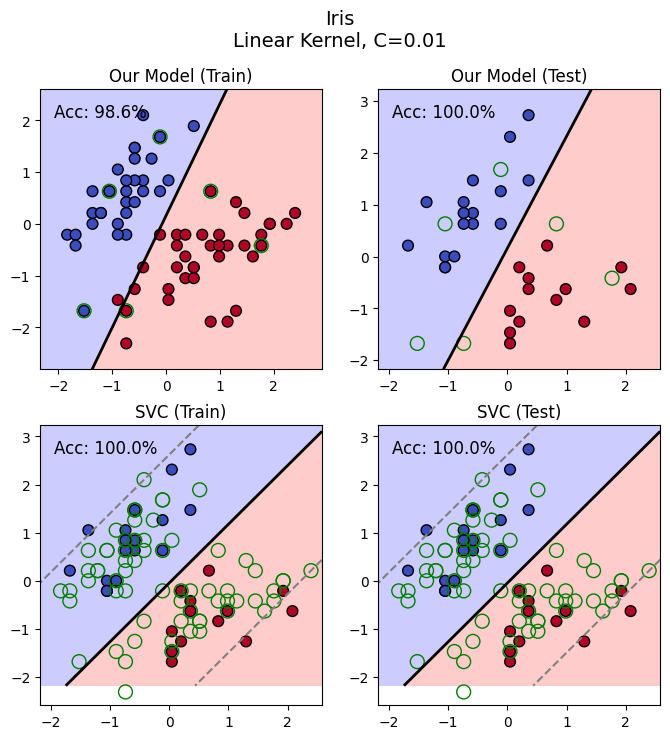

In [ ]:
for dataset in datasets:
    X, y, dataset_name = dataset
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    kernel_configs = [
        ('linear', svm_linear),
        ('rbf', svm_gaussian),
        ('poly', svm_poly)
    ]
    
    for kernel_type, params in kernel_configs:
        for param in params:
            # Инициализация моделей
            if kernel_type == 'linear':
                C = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                sk_model = SVC(kernel='linear', C=C)
                title = f"{dataset_name}\nLinear Kernel, C={C}"
            elif kernel_type == 'rbf':
                C, sigma = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                smo.set_kernel('gaussian', sigma=sigma)
                sk_model = SVC(kernel='rbf', C=C, gamma=1/(2*sigma**2))
                title = f"{dataset_name}\nRBF Kernel, C={C}, σ={sigma}"
            elif kernel_type == 'poly':
                C, degree = param
                smo = KeerthiSmo(X_train, y_train, C=C)
                smo.set_kernel('polynomial', degree=degree)
                sk_model = SVC(kernel='poly', C=C, degree=degree)
                title = f"{dataset_name}\nPoly Kernel, C={C}, degree={degree}"
            
            # Обучение моделей
            smo.train()
            sk_model.fit(X_train, y_train)
            
            # Создание графиков
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))
            fig.suptitle(title, fontsize=14)
            
            # Визуализация для нашей модели и SVC
            plot_data_smo(smo, X_train, y_train, 'Our Model (Train)', ax1)
            plot_data_smo(smo, X_test, y_test, 'Our Model (Test)', ax2)
            plot_data_sk(sk_model, X_test, y_test, 'SVC (Train)', ax3)
            plot_data_sk(sk_model, X_test, y_test, 'SVC (Test)', ax4)


            plt.tight_layout()
            plt.show()

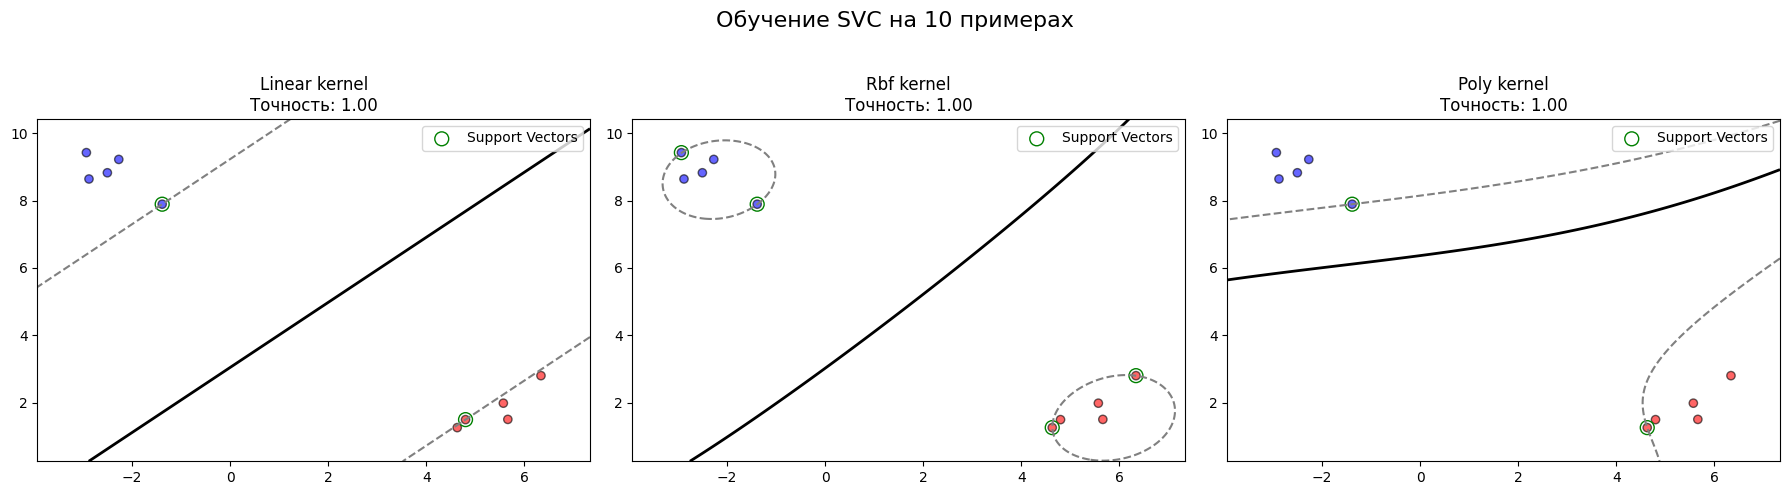

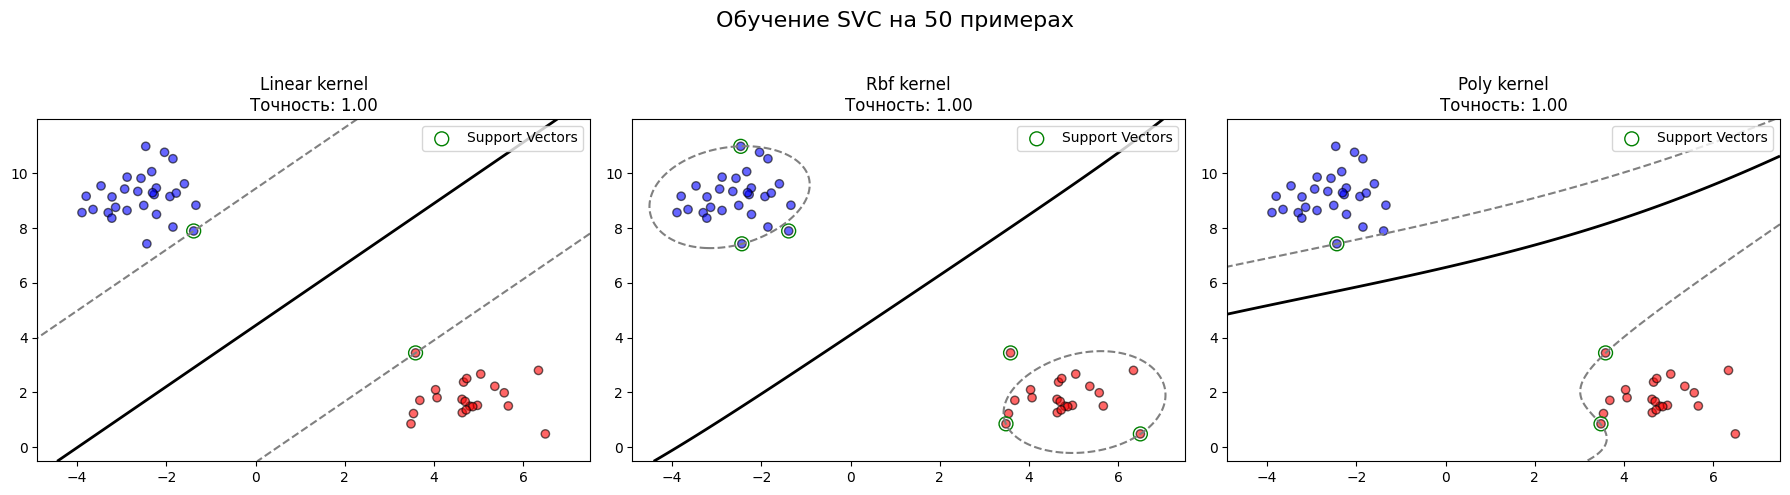

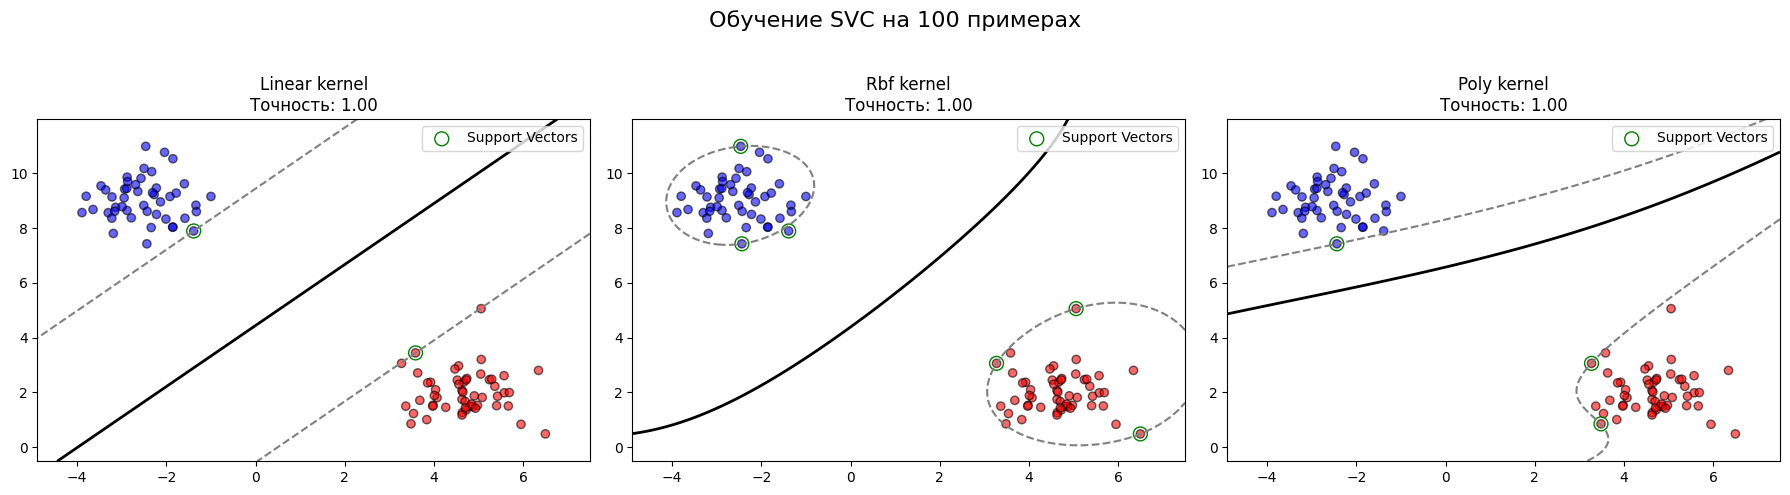

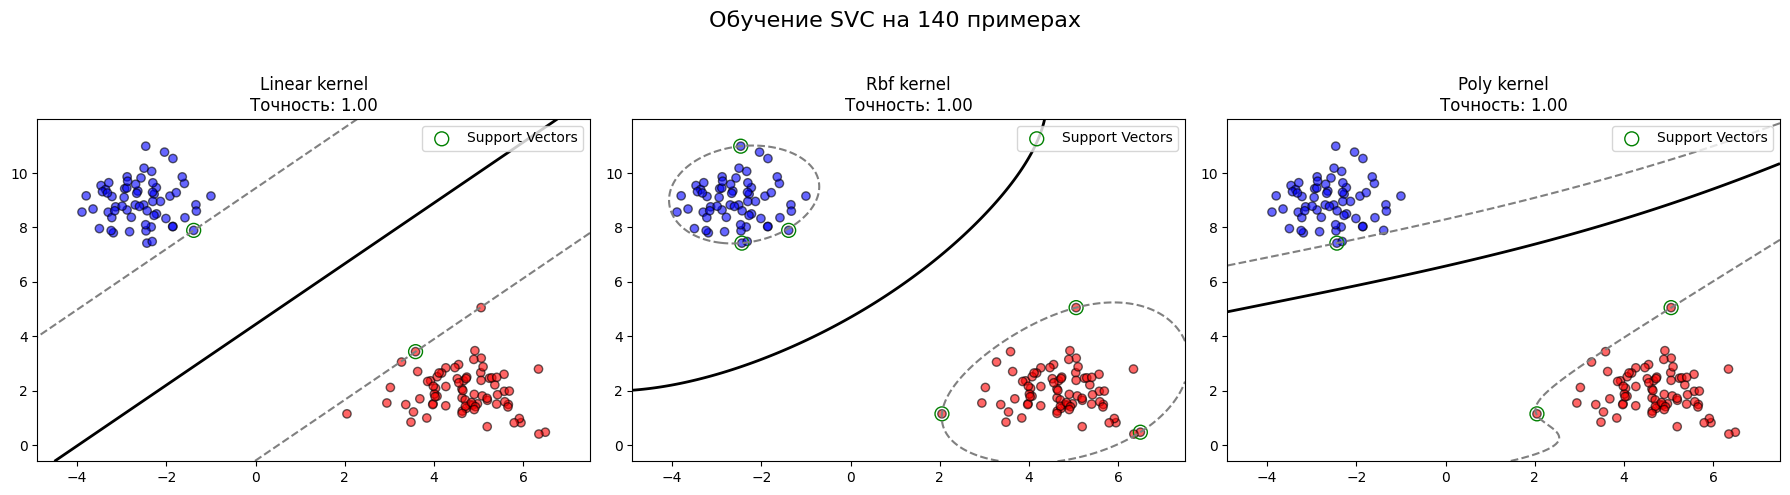

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_blobs
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# # Функция для визуализации решений SVC (с разделяющей линией, линиями margin и опорными векторами)
# def plot_decision_boundary_sklearn(model, X, y, ax=None):
#     if ax is None:
#         ax = plt.gca()
#     # Отображение точек данных
#     ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.6)
    
#     # Создаем сетку для отрисовки границы
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
#                          np.linspace(y_min, y_max, 200))
#     grid = np.c_[xx.ravel(), yy.ravel()]
    
#     # Вычисляем значение функции принятия решения
#     Z = model.decision_function(grid).reshape(xx.shape)
    
#     # Основная разделяющая линия: f(x)=0
#     ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2, linestyles='-')
    
#     # Линии, соответствующие margin: f(x)=+1 и f(x)=-1
#     ax.contour(xx, yy, Z, levels=[-1, 1], colors='gray', linewidths=1.5, linestyles='--')
    
#     # Отображаем опорные векторы
#     ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
#                s=100, facecolors='none', edgecolors='g', label='Support Vectors')
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     ax.set_title(f"SVC (kernel={model.kernel})")
#     ax.legend()

# # Генерируем линейно разделимые данные с помощью make_blobs
# X, y = make_blobs(n_samples=200, centers=2, cluster_std=0.8, random_state=42)
# # Приводим метки к ±1
# y = np.where(y == 0, -1, 1)

# # Разбиваем данные на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Задаем набор "снимков": количество обучающих примеров, на которых будем тренировать SVM
# snapshot_indices = [10, 50, 100, len(X_train)]

# # Определяем список ядер для сравнения
# kernels = ['linear', 'rbf', 'poly']

# # Для каждого количества обучающих примеров (snapshot) обучаем SVC с каждым ядром
# for snapshot in snapshot_indices:
#     fig, axes = plt.subplots(1, 3, figsize=(18, 5))
#     fig.suptitle(f"Обучение SVC на {snapshot} примерах", fontsize=16)
    
#     # Берем первые snapshot примеров из обучающей выборки
#     X_train_subset = X_train[:snapshot]
#     y_train_subset = y_train[:snapshot]
    
#     for idx, kernel in enumerate(kernels):
#         # Для полиномиального ядра можно задать degree и coef0; здесь используются значения по умолчанию
#         model = SVC(kernel=kernel, C=1.0)
#         model.fit(X_train_subset, y_train_subset)
#         # Вычисляем точность на тестовой выборке
#         acc = model.score(X_test, y_test)
#         # Отрисовываем решение на подграфике
#         ax = axes[idx]
#         plot_decision_boundary_sklearn(model, X_train_subset, y_train_subset, ax=ax)
#         ax.set_title(f"{kernel.capitalize()} kernel\nТочность: {acc:.2f}")
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()
